[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SlimeVRX/SlimeVRX/blob/main/hipnuc/document/12.ipynb)

#**Study [Attitude for IMU & AHRS](https://zhuanlan.zhihu.com/p/351596374)**
##**Lesson 12: More Examples of Inertial Navigation Solutions** [(惯导解算的更多例子)](https://zhuanlan.zhihu.com/p/103191168)

> Bài viết này tiếp tục đưa ra một số ví dụ về các giải pháp điều hướng quán tính. Tiếp tục hiểu biết sâu sắc hơn.

Ví dụ 1:

Lần này tôi không hài lòng với giải pháp tĩnh, đây là một số dữ liệu mô phỏng, đây là một chương trình mô phỏng đo lường việc lái xe trên đường bằng phẳng, góc Pitch và góc Roll về cơ bản là 0. Dữ liệu được tạo từ phần mềm nguồn mở [này](https://github.com/Aceinna/gnss-ins-sim)

Phần chương trình của giải pháp dẫn đường quán tính giống hệt như trước, nhưng phần đọc dữ liệu dữ liệu được bổ sung

In [ ]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

cos = np.cos
sin = np.sin
asin = np.arcsin
atan2 = np.arctan2

In [ ]:
# !git clone https://github.com/SlimeVRX/SlimeVRX.git

Cloning into 'SlimeVRX'...
remote: Enumerating objects: 219, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 219 (delta 92), reused 114 (delta 45), pack-reused 0
Receiving objects: 100% (219/219), 6.67 MiB | 20.89 MiB/s, done.
Resolving deltas: 100% (92/92), done.


In [ ]:
from numpy.linalg import norm
def ch_qnormlz(q):
    q = q / norm(q,2)
    if q[0] < 0:
        q[0] = -q[0]
        q[1] = -q[1]
        q[2] = -q[2]
        q[3] = -q[3]
    return q

def ch_rv2q(rv):
    nm2 = rv.dot(rv)
    if nm2 < 1.e-8:
        q0 = 1-nm2*(1/8-nm2/384)
        s = 1/2-nm2*(1/48-nm2/3840)
    else:
        nm = np.sqrt(nm2)
        q0 = cos(nm/2)
        s = sin(nm/2)/nm
    q = np.concatenate([[q0],s*rv])
    return q

def ch_qmul(q1, q2):
    q = np.array([ q1[0] * q2[0] - q1[1] * q2[1] - q1[2] * q2[2] - q1[3] * q2[3],
                   q1[0] * q2[1] + q1[1] * q2[0] + q1[2] * q2[3] - q1[3] * q2[2],
                   q1[0] * q2[2] + q1[2] * q2[0] + q1[3] * q2[1] - q1[1] * q2[3],
                   q1[0] * q2[3] + q1[3] * q2[0] + q1[1] * q2[2] - q1[2] * q2[1] ], dtype=np.float64)
    return q

def ch_att_upt(in_, gyr, dt):
    # Véc tơ quay đơn nguyên
    print(gyr)
    rv = gyr * dt
    dq = ch_rv2q(rv)
    
    out = ch_qmul(in_, dq)
    out = ch_qnormlz(out)
    return out

In [ ]:
def ch_qconj(qin):
    return np.concatenate([[qin[0]], -qin[1:]])

def ch_qmulv(q, vin):
    qi = np.concatenate([[0], vin])
    qo = ch_qmul(ch_qmul(q,qi),ch_qconj(q))
    vout = qo[1:]
    return vout

def ch_nav_equ_local_tan(p, v, q ,acc, gyr, dt, gN):
    # Cập nhật giải pháp điều hướng quán tính, hệ tọa độ Descartes cục bộ, không phụ thuộc vào lực hấp dẫn của Trái đất
    # p vị trí XYZ đơn vị m
    # v tốc độ XYZ đơn vị m/s
    # q Attitude Qb2n, Quaternion
    # acc đối chiếu, Phép đo gia tốc kế đơn vị (m/s^2)
    # gyr vận tốc góc đơn vị (rad/s)
    # dt khoảng thời gian tích phân 0.01s
    # gn véc tơ trọng lực cục bộ
    old_v = v
    sf = acc

    # Attitude ...
    q = ch_att_upt(q, gyr, dt)

    # Giải pháp vận tốc / Velocity
    sf = ch_qmulv(q, sf)
    sf = sf + gN
    v = old_v + dt * sf

    # Giải pháp vị trí
    p = p + (old_v + v) * dt / 2
    return p, v, q

def ch_q2eul_312(Qb2n):
    q0 = Qb2n[0]
    q1 = Qb2n[1]
    q2 = Qb2n[2]
    q3 = Qb2n[3]

    roll = -atan2(2 * (q1 * q3 - q0 * q2), q0 * q0 - q1 * q1 - q2 * q2 + q3 * q3)
    pitch = asin(2 * (q0 * q1 + q2 * q3))
    yaw = -atan2(2 * (q1 * q2 - q0 * q3), q0 * q0 - q1 * q1 + q2 * q2 - q3 * q3)
    return pitch, roll, yaw

In [ ]:
annots = sio.loadmat('/content/SlimeVRX/hipnuc/dataset/example_ins2.mat')

pos_gt = np.array(annots['pos_gt'], dtype=np.float64)
pos_gt = pos_gt - pos_gt[0,:]

acc = np.array(annots['acc'], dtype=np.float64)
gyr = np.array(annots['gyr'], dtype=np.float64)

In [ ]:
plt.plot(acc)
plt.title("ACC")
ax = plt.subplot()
ax.legend(["X", "Y", "Z"])

In [ ]:
plt.plot(gyr)
plt.title("GYR")
ax = plt.subplot()
ax.legend(["X", "Y", "Z"])

In [ ]:
N = len(acc)
Fs = 100

p = np.zeros((3), dtype=np.float64)
v = np.zeros((3), dtype=np.float64)
q = np.array([1, 0, 0, 0])

pos = np.zeros((N, 3), dtype=np.float64)
vel = np.zeros((N, 3), dtype=np.float64)
eul = np.zeros((N, 3), dtype=np.float64)

gravity = 9.79444435359668

for i in range(N):
    p, v, q = ch_nav_equ_local_tan(p, v, q, acc[i,:], gyr[i,:], 1/Fs, np.array([0, 0, -gravity]))
    pos[i, :] = p
    vel[i, :] = v
    eul[i, :] = np.rad2deg(ch_q2eul_312(q))

from numpy.linalg import norm
print('Total time:%fs  Final position difference:%f\n' %(N /Fs, norm(pos_gt[N-1, 0:2] - pos[N-1, 0:2], 2)))

Total time:965.930000s  Final position difference:433.500134



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


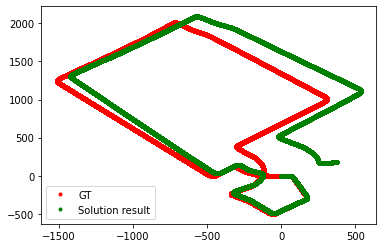

In [ ]:
plt.plot(pos_gt[:,0], pos_gt[:,1], '.r')
plt.plot(pos[:,0], pos[:,1], '.g')
ax = plt.subplot()
ax.legend(["GT", "Solution result"])

Có thể thấy kết quả mô phỏng không quá chênh lệch so với GT (giá trị thực). Nhưng tùy chọn mô phỏng của tôi ở đây là điều chỉnh IMU sang chế độ chính xác cao. Nếu nó được điều chỉnh ở độ chính xác trung bình hoặc thấp, nó sẽ rất kinh khủng.

Ví dụ 2:

Dữ liệu mô phỏng không thể đáp ứng cho chúng ta lần này. Để có được dữ liệu thực, trước tiên chúng ta hãy lấy một dữ liệu tĩnh. Từ dữ liệu con quay hồi chuyển và gia tốc kế tĩnh trong 30 giây được thu thập từ cảm biến CH100 siêu hạng, thực hiện giải pháp điều hướng quán tính ở trạng thái tĩnh để xem:

In [ ]:
annots = sio.loadmat('/content/SlimeVRX/hipnuc/dataset/example_ins3_hi226_static_30s.mat')

acc = np.array(annots['acc'], dtype=np.float64)
gyr = np.array(annots['gyr'], dtype=np.float64)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


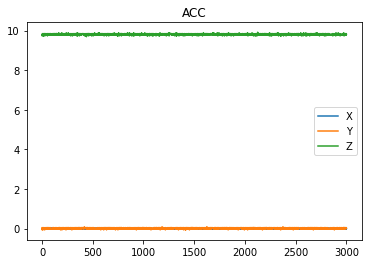

In [ ]:
plt.plot(acc)
plt.title("ACC")
ax = plt.subplot()
ax.legend(["X", "Y", "Z"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


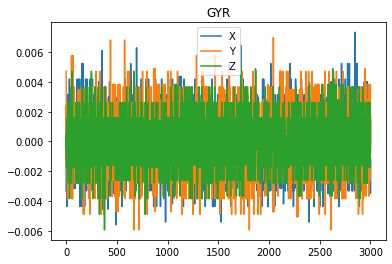

In [ ]:
plt.plot(gyr)
plt.title("GYR")
ax = plt.subplot()
ax.legend(["X", "Y", "Z"])

In [ ]:
N = len(acc)
Fs = 100

# gyr = np.deg2rad(gyr)
# acc = acc*9.795

p = np.zeros((3), dtype=np.float64)
v = np.zeros((3), dtype=np.float64)
q = np.array([1, 0, 0, 0])

pos = np.zeros((N, 3), dtype=np.float64)

for i in range(N):
    p, v, q = ch_nav_equ_local_tan(p, v, q, acc[i,:], gyr[i,:], 1/Fs, np.array([0, 0, -9.795]))
    pos[i, :] = p

print("Total %d data, time: %.3fs\n" %(N, N/Fs))
print("Start position: %.3f %.3f, End position %.3f %.3f, Difference: %.3fm\n" %(pos[0,0], pos[0,1], pos[N-1,0], pos[N-1,1], norm(pos[N-1, 0:2] - pos[0, 0:2], 2)))

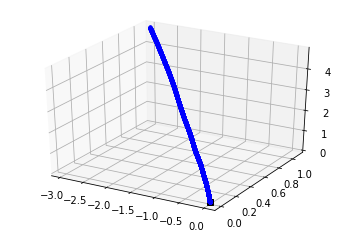

In [ ]:
ax = plt.axes(projection='3d')
ax.plot3D([pos[0,0]], [pos[0,1]], [pos[0,2]], '-ks')
ax.plot3D(pos[:,0], pos[:,1], pos[:,2], '.b')

Kết luận: 

Giải pháp dẫn đường quán tính tĩnh trong 30s đã trôi ra 4 mét. Rất khó để đạt được điều hướng quán tính nếu không có sự hỗ trợ của các cảm biến khác cho MEMS có giá vài đô la. Thiết bị MEMS giá rẻ này chỉ có thể thu được thông tin về Attitude tương đối thực tế. Về vị trí, nếu không có sự hỗ trợ của các cảm biến khác thì khó có giá trị thực tế.

Ví dụ 3:

Đối với dữ liệu thực, sử dụng cảm biến độ chính xác cao CH100 để thực hiện một chuyển động cơ bản trong khoảng 5 giây. Sau đó, thu thập dữ liệu IMU, thực hiện giải pháp điều hướng quán tính và xem nó trông như thế nào:

In [ ]:
annots = sio.loadmat('/content/SlimeVRX/hipnuc/dataset/example_ins4.mat')

In [ ]:
acc_x = np.array(annots['acc'], dtype=np.float64)[0]
acc_y = np.array(annots['acc'], dtype=np.float64)[1]
acc_z = np.array(annots['acc'], dtype=np.float64)[2]

gyr_x = np.array(annots['gyr'], dtype=np.float64)[0]
gyr_y = np.array(annots['gyr'], dtype=np.float64)[1]
gyr_z = np.array(annots['gyr'], dtype=np.float64)[2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


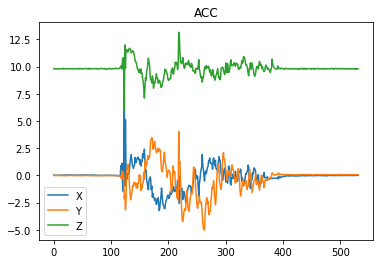

In [ ]:
plt.plot(acc_x)
plt.plot(acc_y)
plt.plot(acc_z)
plt.title("ACC")
ax = plt.subplot()
ax.legend(["X", "Y", "Z"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


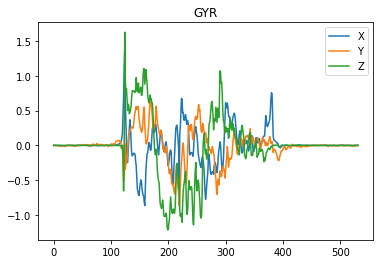

In [ ]:
plt.plot(gyr_x)
plt.plot(gyr_y)
plt.plot(gyr_z)
plt.title("GYR")
ax = plt.subplot()
ax.legend(["X", "Y", "Z"])

In [ ]:
N = 532
Fs = 100

p = np.zeros((3), dtype=np.float64)
v = np.zeros((3), dtype=np.float64)
q = np.array([1, 0, 0, 0])

pos = np.zeros((N, 3), dtype=np.float64)
eul = np.zeros((N, 3), dtype=np.float64)

for i in range(N):
    p, v, q = ch_nav_equ_local_tan(p, v, q, np.array([acc_x[i], acc_y[i], acc_z[i]]), np.array([gyr_x[i], gyr_y[i], gyr_z[i]]), 1/ Fs, np.array([0, 0, -9.8]))
    pos[i, :] = p
    eul[i, :] = np.rad2deg(ch_q2eul_312(q))

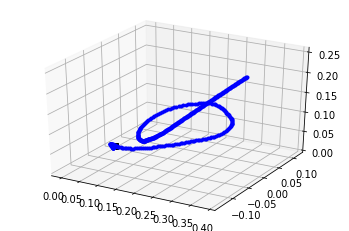

In [ ]:
# plt.plot(pos)
ax = plt.axes(projection='3d')
ax.plot3D([pos[0,0]], [pos[0,1]], [pos[0,2]], '-ks')
ax.plot3D(pos[:,0], pos[:,1], pos[:,2], '.b')

Ví dụ 4:

.

.

.

In [ ]:
Fs = 100
N = 1000

dt = 1 / Fs
gyr = np.array([0.01, 0.02, 0.03])
acc = np.array([0, 0, 9.8])

p = np.zeros((3), dtype=np.float64)
v = np.zeros((3), dtype=np.float64)
q = np.array([1, 0, 0, 0])

pos = np.zeros((N, 3), dtype=np.float64)
vel = np.zeros((N, 3), dtype=np.float64)
eul = np.zeros((N, 3), dtype=np.float64)

for i in range(N):
    p, v, q = ch_nav_equ_local_tan(p, v, q, acc, gyr, 1/ Fs, np.array([0, 0, -9.8]))
    pos[i, :] = p
    vel[i, :] = v
    eul[i, :] = np.rad2deg(ch_q2eul_312(q))

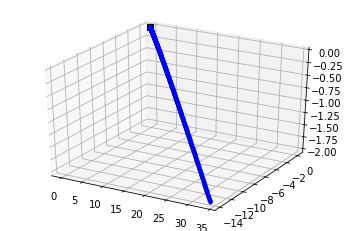

In [ ]:
ax = plt.axes(projection='3d')
ax.plot3D([pos[0,0]], [pos[0,1]], [pos[0,2]], '-ks')
ax.plot3D(pos[:,0], pos[:,1], pos[:,2], '.b')

Tóm tắt

- Nếu bạn phải phân tích chuyển động theo quỹ đạo với con quay hồi chuyển MEMS giá rẻ, toàn bộ thời gian chuyển động vẫn có thể có một số giá trị ở mức ms (chẳng hạn như phân tích và phân tích cú ném, cú đánh gôn có kích thước hàng chục ms). Nếu bạn muốn thực hiện điều hướng, tính toán quỹ đạo trong thời gian dài mà không cần sự hỗ trợ của các cảm biến khác (đồng hồ đo đường, GPS), đó chỉ đơn giản là một giấc mơ.
- Trên đây là tất cả được thu thập ở 100Hz và được tính toán ở 100Hz. Tôi đã cố gắng điều chỉnh đầu ra CH100 thành 400Hz, sau đó giải quyết ở 400Hz. Kết quả là cải thiện được khoảng 50%, nhưng vẫn không có gì ngạc nhiên, không có giá trị sử dụng. Nếu một IMU vài trăm đô la có thể duy trì quỹ đạo trong một thời gian dài, thì VSLAM và sự hợp nhất **quán tính-thị giác** có giá trị gì?